In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from time import time
from statsmodels.tsa.stattools import adfuller

# Data

In [4]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [10]:
catfish_sales = pd.read_csv('O:\\catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
Freq: MS, Name: Total, dtype: int64

In [12]:
start_date = datetime(2000,1,1)
end_date = datetime(2004,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

Date
2000-01-01    25412
2000-02-01    25354
2000-03-01    29161
Freq: MS, Name: Total, dtype: int64

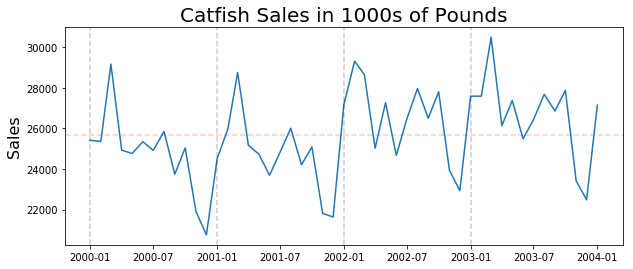

In [14]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(lim_catfish_sales.mean(), color='r', alpha=0.2, linestyle='--')

In [19]:
# Augmented Dickey-Fuller test
result = adfuller(lim_catfish_sales)
print('ADF Statistic', result[0])
print('p-value', result[1]) # p-value > 0.05 => not stationary, thus we try to take the first difference

ADF Statistic -0.4581291591351324
p-value 0.8999315929015703


ADF Statistic -8.052801250811912
p-value 1.7239228907576701e-12


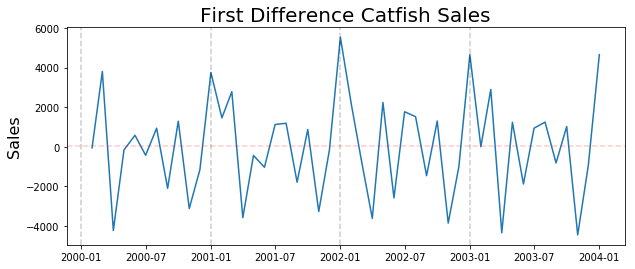

In [34]:
first_diff = lim_catfish_sales.diff()[1:]

# Augmented Dickey-Fuller test
result = adfuller(first_diff)
print('ADF Statistic', result[0])
print('p-value', result[1]) # p-value < 0.05 => stationary

plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('First Difference Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(first_diff.mean(), color='r', alpha=0.2, linestyle='--')

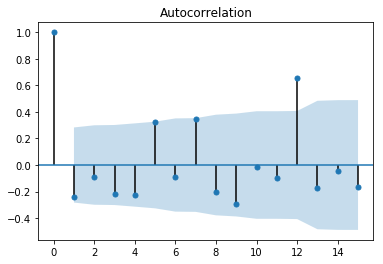

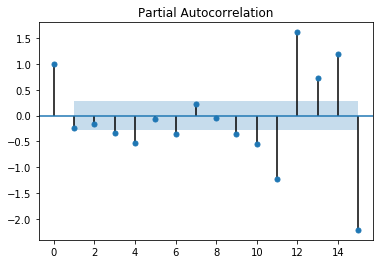

In [36]:
acf_plot = plot_acf(first_diff, lags=15)
pacf_plot = plot_pacf(first_diff, lags=15)

**Remark :** Spikes at 12 indicates a possible seasonality pattern (annual)

Choice of model : ARMA(4,1)

In [39]:
train_end = datetime(2003,7,1)
test_end = datetime(2004,1,1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

model = ARMA(train_data, order=(4,1))

model_fit = model.fit()

print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Total   No. Observations:                   42
Model:                     ARMA(4, 1)   Log Likelihood                -376.584
Method:                       css-mle   S.D. of innovations           1850.781
Date:                Mon, 11 Nov 2024   AIC                            767.167
Time:                        17:13:21   BIC                            779.331
Sample:                    02-01-2000   HQIC                           771.626
                         - 07-01-2003                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.2883    129.751      0.287      0.775    -217.019     291.595
ar.L1.Total    -0.8666      0.185     -4.692      0.000      -1.229      -0.505
ar.L2.Total    -0.4236      0.166     -2.547    

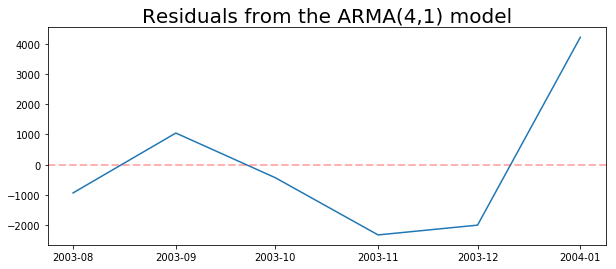

In [44]:
predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

residuals = test_data - predictions

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from the ARMA(4,1) model', fontsize=20)
plt.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.3)

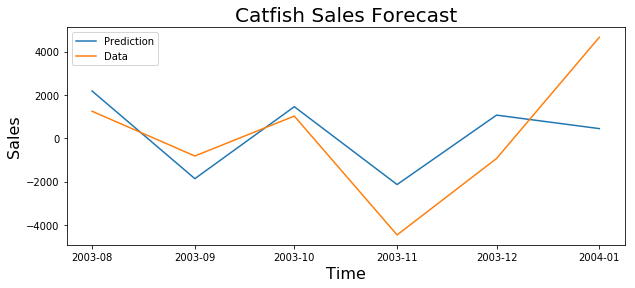

In [47]:
plt.figure(figsize=(10,4))
plt.plot(predictions, label='Prediction')
plt.plot(test_data, label='Data')
plt.title('Catfish Sales Forecast', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.legend()

In [48]:
# Precision evaluation metrics
print('Mean Absolute Percentage Error :', np.mean(abs(residuals/test_data))) # Mean absolute percentage error
print('Root Mean Squared Error :', np.sqrt(np.mean(residuals**2)))           # Root mean squared error

Mean Absolute Percentage Error : 1.0028462061161598
Root Mean Squared Error : 2210.2703843691856
